In [1]:
from jax import vmap
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time
from equinox_module import training_MODEL, create_FNN, save_MODEL, load_FNN

In [2]:
alpha = 0.1
beta  = 9.80665

def f(x):
    return jnp.array([x[1], -alpha*x[1] - beta*jnp.sin(x[0])]) # Derivatives

In [3]:
dt = 0.01
T_final = 1.0
NUM_TRAJS = 900
NUM_STEPS = T_final // dt
SEED = 1234

key = jr.PRNGKey(SEED)
key, subkey_model, subkey_tr, subkey_tt = jr.split(key, num=4)
initial_states = jr.uniform(subkey_tr, (NUM_TRAJS, 2), minval=jnp.array([-jnp.pi/2, -jnp.pi]), maxval=jnp.array([jnp.pi/2, jnp.pi]))

In [4]:
def rollout_fn(f, n, dt, include_init: bool = False):
    def scan_fn(u, _):
        # RK 45 Numerical Integrator
        k1 = dt * f(u)
        k2 = dt * f(u + 0.5*k1)
        k3 = dt * f(u + 0.5*k2)
        k4 = dt * f(u + k3)
        u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
        return u_next, u_next

    def rollout_fn(u_0):
        _, trj = jax.lax.scan(scan_fn, u_0, None, length=n)

        if include_init:
            return jnp.concatenate([jnp.expand_dims(u_0, axis=0), trj], axis=0)

        return trj

    return rollout_fn

In [5]:
RK45_integrator = lambda x: rollout_fn(f, NUM_STEPS, dt, include_init=True)(x)
trajectories = vmap(RK45_integrator)(initial_states)   

In [6]:
trajectories.shape

(900, 100, 2)

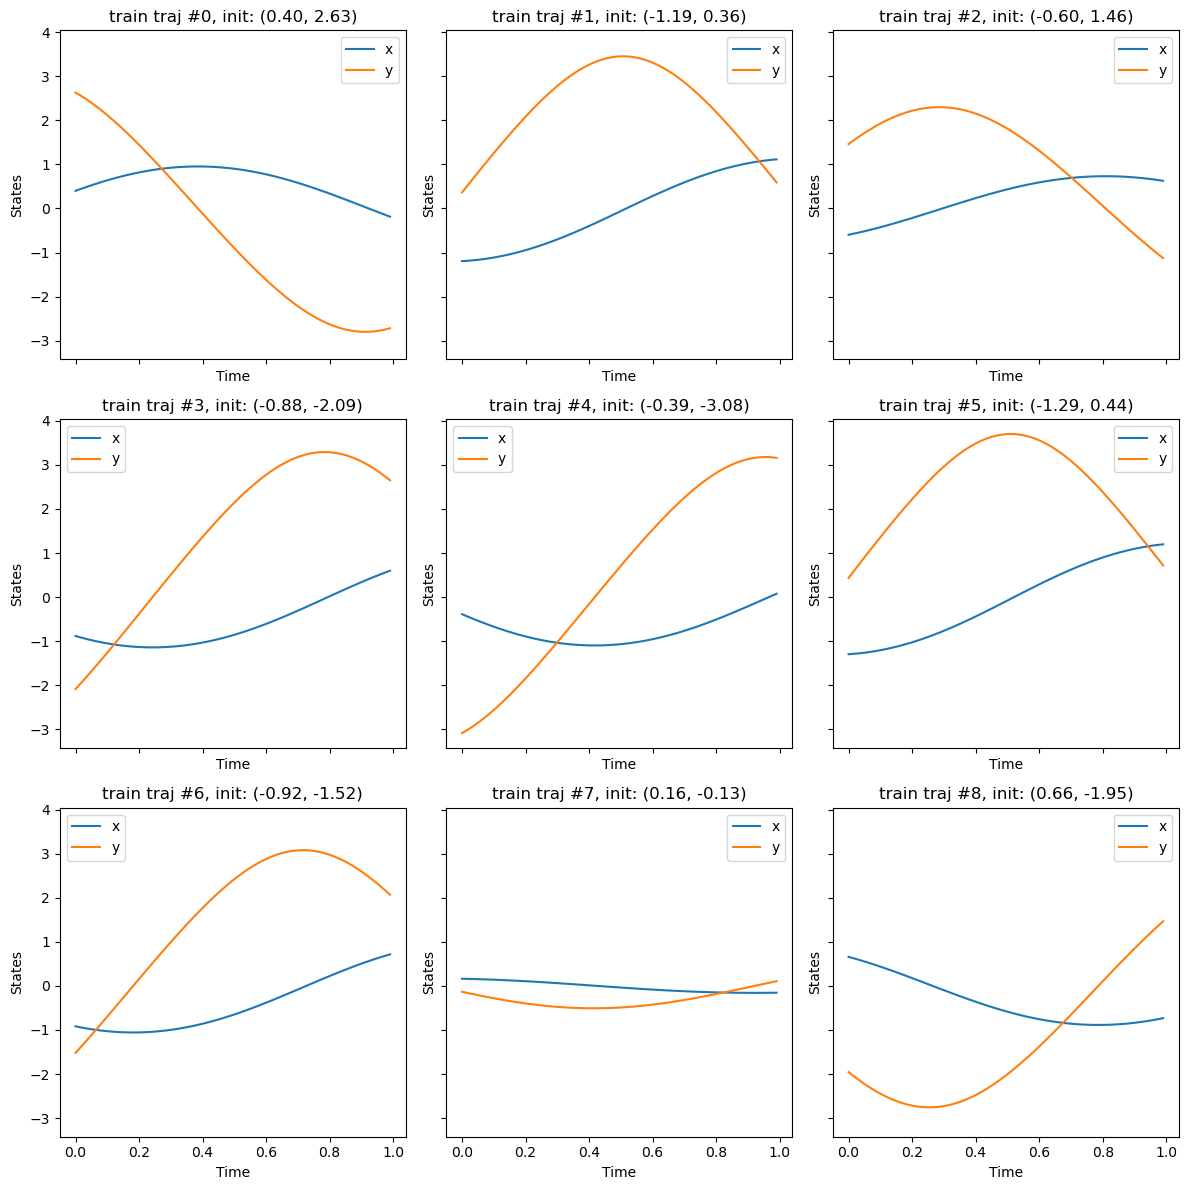

In [7]:
t = jnp.arange(0.0, T_final, dt)
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
axe = axes.flatten()
for i in range(len(axe)):
    axe[i].plot(t, trajectories[i,:, 0], label='x')
    axe[i].plot(t, trajectories[i,:, 1], label='y')
    axe[i].set_xlabel('Time')
    axe[i].set_ylabel('States')
    axe[i].legend()
    axe[i].set_title(f'train traj #{i}, init: ({initial_states[i][0]:.2f}, {initial_states[i][1]:.2f})')
plt.tight_layout()
plt.show()

In [ ]:
SEED = 10

INPUT_DIM  = 2
WIDTH      = 20
DEPTH      = 4
ACTIVATION = 'sine'
# sine, cosine, relu, tanh, gelu, swish

HYPER_MODEL = {"input_dim": INPUT_DIM, 
               "output_dim": INPUT_DIM, 
               "width": WIDTH,
               "depth": DEPTH-1, 
               "act_func": ACTIVATION}

model = create_FNN(key=subkey_model, **HYPER_MODEL)

In [ ]:
LEARNING_RATE = 1e-3
OPTIMIZER_NAME = 'adam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 2_000
PRINT_EVERY = 1_00

LR_SCHEDULER = 'constant' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 1000

LBFGS_USE = 'on'
LBFGS_MAXITER = 1_000
LBFGS_PRINT_EVERY = 1_00
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0

In [10]:
HYPER_OPTIM = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }

In [16]:
def loss_fn(model):
    residual = vmap(lambda x: rollout_fn(model, NUM_STEPS, dt, include_init=False)(x))(trajectories[:, 0, :]) - trajectories[:, 1:, :]
    return jnp.mean(residual**2)

In [17]:
start_time = time.time()
model, log_loss, log_minloss = training_MODEL(model, loss_fn, HYPER_OPTIM)
end_time = time.time()

Selected Optimizer is [ adam ], Initial Learning Rate is 1.00e-03
You are using [ exponential ] learning rate scheduler with rate: 0.90 and step: 1000
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch    0: loss = 4.2572e+00, minloss = 4.2572e+00, Time: 0.76s
Epoch  100: loss = 2.5474e-01, minloss = 2.5474e-01, Time: 51.70s
Epoch  200: loss = 5.0305e-02, minloss = 5.0305e-02, Time: 55.54s
Epoch  300: loss = 1.7114e-02, minloss = 1.7114e-02, Time: 56.74s
Epoch  400: loss = 7.2163e-03, minloss = 7.2163e-03, Time: 57.40s
Epoch  500: loss = 3.1736e-03, minloss = 3.1736e-03, Time: 57.61s
Epoch  600: loss = 1.7756e-03, minloss = 1.7756e-03, Time: 57.71s
Epoch  700: loss = 1.3031e-03, minloss = 1.3031e-03, Time: 57.46s
Epoch  800: loss = 1.0633e-03, minloss = 1.0633e-03, Time: 57.54s
Epoch  900: loss = 9.0483e-04, minloss = 9.0483e-04, Time: 57.96s
Epoch 1000: loss = 7.8875e-04, minloss = 7.8875e-04, Time:

In [24]:
NUM_TT_TRAJS = 100
NUM_STEPS_TT = 10 * T_final // dt
tt = jnp.arange(0.0, 10*T_final, dt)

initial_states_test = jr.uniform(subkey_tt, (NUM_TT_TRAJS, 2), minval=jnp.array([-jnp.pi/2, -jnp.pi]), maxval=jnp.array([jnp.pi/2, jnp.pi]))
test_trajectories = vmap(lambda x: rollout_fn(f, NUM_STEPS_TT, dt, include_init=True)(x))(initial_states_test)
NN_trajectories = vmap(lambda x: rollout_fn(model, NUM_STEPS_TT, dt, include_init=True)(x))(initial_states_test)

In [25]:
rel_l2_error_overTraj = jnp.sqrt(jnp.sum((test_trajectories - NN_trajectories)**2,axis=0) / jnp.sum(test_trajectories**2,axis=0))

Avg. Relative L2 error     : 8.6055e-03


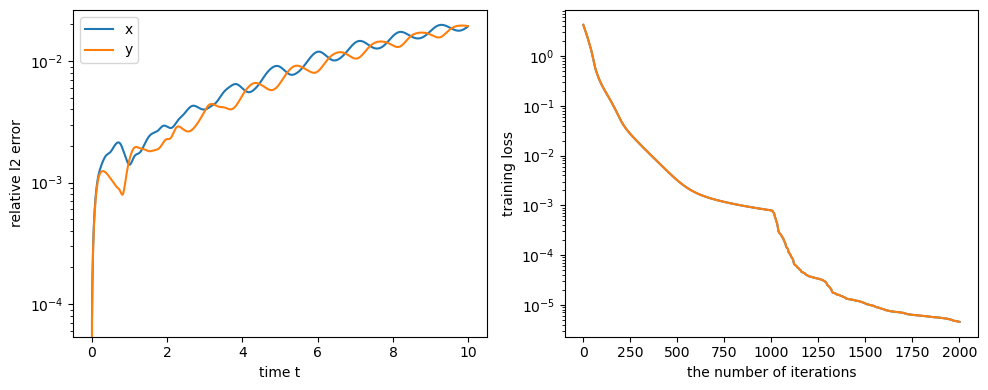

In [26]:
rel_l2_error = jnp.sqrt(jnp.sum((test_trajectories - NN_trajectories)**2) / jnp.sum(test_trajectories**2))
print(f"Avg. Relative L2 error     : {jnp.mean(rel_l2_error):.4e}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].semilogy(tt,rel_l2_error_overTraj[:,0], label='x')
axes[0].semilogy(tt,rel_l2_error_overTraj[:,1], label='y')
axes[0].set_xlabel('time t')
axes[0].set_ylabel('relative l2 error')
axes[0].legend()
axes[1].semilogy(log_loss)
axes[1].semilogy(log_minloss)
axes[1].set_xlabel('the number of iterations')
axes[1].set_ylabel('training loss')
plt.tight_layout()
# plt.suptitle(title_str + '\n')
plt.show()

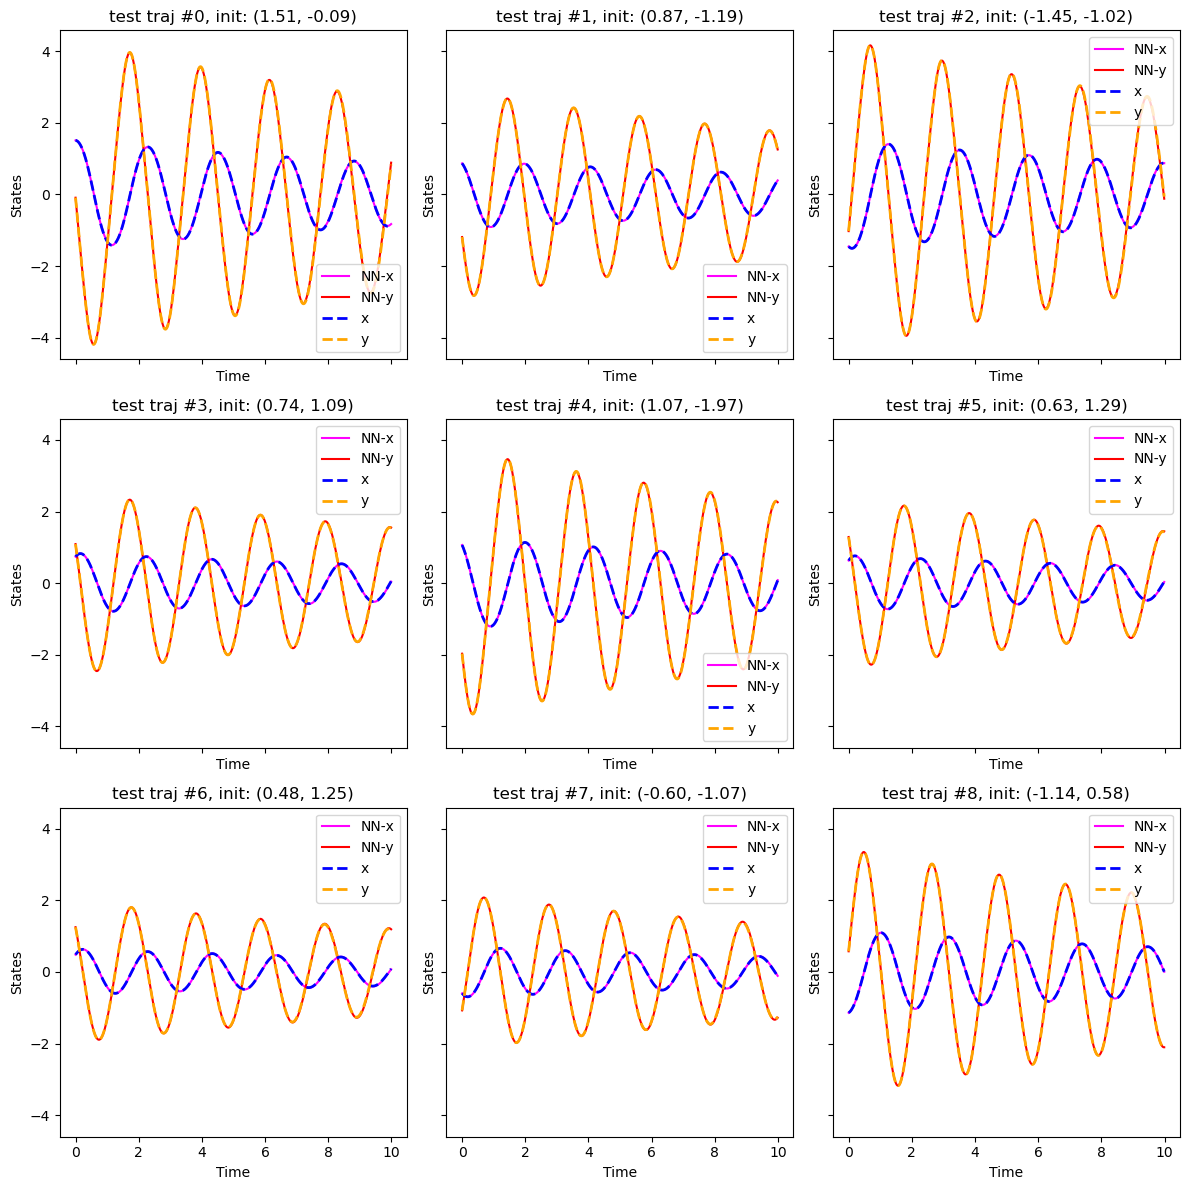

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
axe = axes.flatten()
for i in range(len(axe)):
    axe[i].plot(tt, NN_trajectories[i,:, 0], label='NN-x', color='magenta')
    axe[i].plot(tt, NN_trajectories[i,:, 1], label='NN-y', color='red')
    axe[i].plot(tt, test_trajectories[i,:, 0], label='x', color='blue', linestyle='--', linewidth=2)
    axe[i].plot(tt, test_trajectories[i,:, 1], label='y', color='orange', linestyle='--', linewidth=2)
    axe[i].set_xlabel('Time')
    axe[i].set_ylabel('States')
    axe[i].legend()
    axe[i].set_title(f'test traj #{i}, init: ({initial_states_test[i][0]:.2f}, {initial_states_test[i][1]:.2f})')
plt.tight_layout()
plt.show()

In [ ]:
# save_MODEL('DeepONet_HeatEqn.eqx',HYPER_MODEL,model)

In [ ]:
# loaded_model = load_DeepONet('DeepONet_Diff.eqx')